# An example of EEG preprocessing with MNE python

This is an example on how to preprocess EEG data with [MNE](https://mne.tools/stable/index.html). Obviously there are many ways to preprocess EEG data, this template is intended for people using [Hidden semi-Markov Models with pattern analysis (HMP)](https://github.com/GWeindel/hsmm_mvpy) but others might find it useful.

I usually preprocess EEG in a notebook using MNE and save one notebook per participant I prepreocessed. This allows me to later retrieve the information on what particular steps were taken for each individual and also eventually change some steps without having to run all the notebook again.

In [1]:
name_subj = "VP1"#Data is dynamically read and saved based on this string, adapt to the number of your participant

#Necessary library
import mne#preprocessing and plotting
import os#file and path handling
import numpy as np#Numerical computations
import pandas as pd#data frame handling
import matplotlib.pyplot as plt#plotting

print(f'MNE version is {mne.__version__}')
%matplotlib inline
#plot within notebook, useful for later sharing
EEG_data_path = '../data/eeg/'

MNE version is 1.4.2


# Reading raw BDF

This data was recorded using a biosemi 32 channel system.

Extracting EDF parameters from C:\Users\maane008\Dropbox\Projects\EEG-PRP\data\eeg\raw\VP1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1836543  =      0.000 ...  3586.998 secs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\2665286474.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=200, picks='eeg');#First glimpse at the coarse frequnecy composition of the data
C:\Users\maane008\Anaconda3\envs\hmp\lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


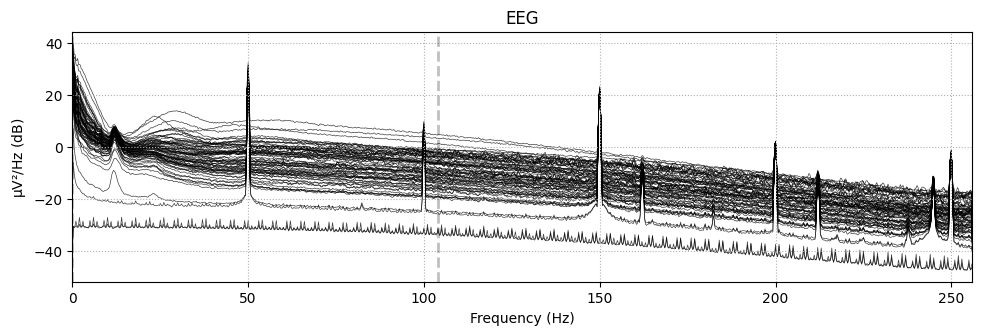

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2016-11-03 16:29:53 UTC
 nchan: 73
 projs: []
 sfreq: 512.0 Hz
>

In [2]:
raw = mne.io.read_raw_bdf(EEG_data_path+'raw/%s.bdf'%name_subj,preload=True, verbose=True)
raw.plot_psd(tmin=200, picks='eeg');#First glimpse at the coarse frequnecy composition of the data
plt.show()
raw.info#Info structure about the data

#  Setting up bipolar references and montage

Note that everything is done inplace, meaning that e.g. if you drop channels they will no longer be present in the original ```raw``` variable

In [3]:
# Setting the reference
# according to biosemi manual:
#EXG1: 2cm above the right eye (aligned to center of eye)
#EXG2: 2cm below the right eye (aligned to center of eye)
#EXG3: 1cm right of the right eye (aligned to center of eye)
#EXG4: 1cm left of the left eye (aligned to center of eye)
#EXG5: On right mastoid behind right ear (reference)
#EXG6: On left mastoid behind left ear (reference)
#raw.set_eeg_reference(ref_channels=["EXG5","EXG6"])
mne.set_bipolar_reference(raw,anode=['EXG3','EXG1'],cathode=['EXG4','EXG2'],ch_name=['eog_h', 'eog_v'],copy=False, drop_refs=False) 
raw.set_channel_types({'eog_h':'eog', 'eog_v':'eog'})
raw.drop_channels(['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])#No longer need those
raw.set_montage('biosemi64') #apply standard biosemi 64 electrode montage as we do not have measure of actual electrode position

#Renaming EEG electrodes to biosemi names
#dict_to_biosemi = dict(zip(raw.copy().pick_types(eeg=True).ch_names, mne.channels.make_standard_montage('biosemi64').ch_names))
#raw.rename_channels(dict_to_biosemi) #tocheck
#raw.set_montage('biosemi64') #apply standard biosemi 64 electrode montage as we do not have measure of actual electrode position


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=2, n_times=1836544
    Range : 0 ... 1836543 =      0.000 ...  3586.998 secs
Ready.
Added the following bipolar channels:
eog_h, eog_v


<RawEDF | VP1.bdf, 67 x 1836544 (3587.0 s), ~938.9 MB, data loaded>

We see that the info object is now updated according to the modifications done

# Checking for bad electrodes

Visual inspection to detect fault electrodes (flat, very noisy, unstable for long period of times). Do not worry about occasional glitches as these will be fixed at the last stage of the pipeline

In [4]:
%matplotlib qt
raw.set_eeg_reference('average')#For electrode check only
raw.plot(block=True, n_channels=72, scalings=100e-6);#plotting function, block argument stops notebook execution, useful if you just want to run the whole notebook

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using qt as 2D backend.
Channels marked as bad:
none


Additionally it is possible to check bridged electrode (https://mne.tools/dev/auto_examples/preprocessing/eeg_bridging.html). Necessary? there are 64 electrodes

In [5]:
raw.info['bads'] 

[]

## REST reference

Then we apply a REST reference (see https://iopscience.iop.org/article/10.1088/0967-3334/22/4/305/meta)

In [6]:
# Setting the reference, REST 
sphere = mne.make_sphere_model('auto', 'auto', raw.info, verbose=False)
src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15., verbose=False)
forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere, verbose=False)
raw.set_eeg_reference('REST', forward=forward);

EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    64 out of 64 channels remain after picking


# Filtering

Low, high pass filter + notchfilter at 50Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


C:\Users\maane008\Anaconda3\envs\hmp\lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


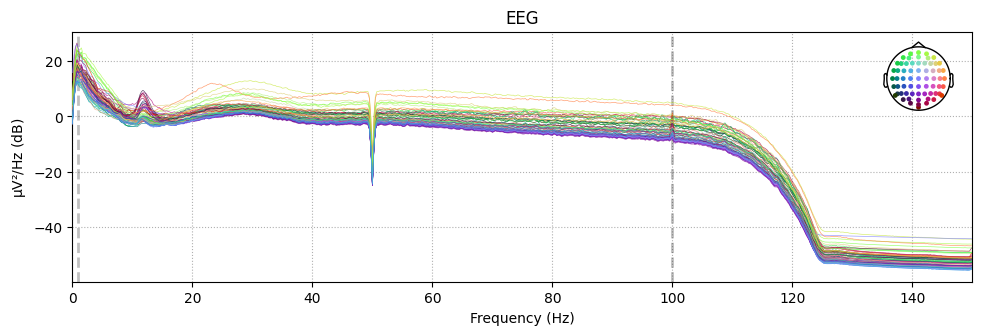

In [7]:
%matplotlib inline
raw.filter(1, 100, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') #Filtering between 1 and 100 Hz
raw.notch_filter(freqs=50)#In this experiment 50Hz for all participants so notch filter needed
raw.plot_psd(tmin=200, fmax=150, picks='eeg')#rechecking frequency decomposition
plt.show()

I save the data, hence saving the montage, the low-pass filtered data, the (eventual) annotation of the bad channel

In [8]:
raw.save(EEG_data_path+"preproc/pre_rejection_%s.fif"%name_subj,overwrite=True) #save data in .fif format

Overwriting existing file.
Writing C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\pre_rejection_VP1.fif


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\483517137.py:1: RuntimeWarning: This filename (C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\pre_rejection_VP1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(EEG_data_path+"preproc/pre_rejection_%s.fif"%name_subj,overwrite=True) #save data in .fif format


Closing C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\pre_rejection_VP1.fif
[done]


# Rejecting artefacts

First we recover the events from the trigger channel

Opening raw data file ../data/eeg/preproc/pre_rejection_VP1.fif...
    Range : 0 ... 1836543 =      0.000 ...  3586.998 secs
Ready.
Reading 0 ... 1836543  =      0.000 ...  3586.998 secs...


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\1302542746.py:1: RuntimeWarning: This filename (../data/eeg/preproc/pre_rejection_VP1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(EEG_data_path+"preproc/pre_rejection_%s.fif"%name_subj, preload=True)#needed just in case of restart at this point


Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5391 events found
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65  66 128 129
 130 131 132]


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\1302542746.py:4: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events);


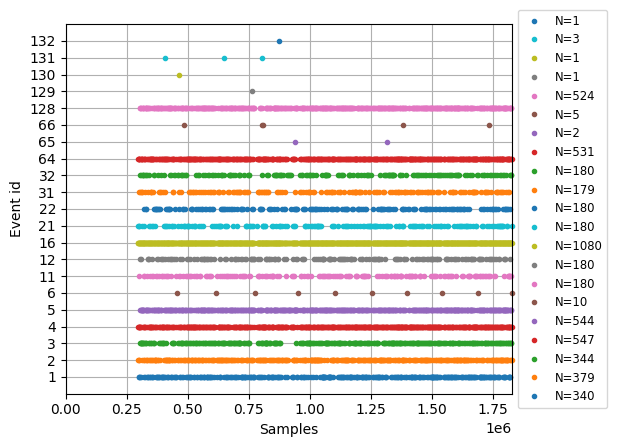

In [9]:
raw = mne.io.read_raw_fif(EEG_data_path+"preproc/pre_rejection_%s.fif"%name_subj, preload=True)#needed just in case of restart at this point

events = mne.find_events(raw,min_duration= 2 / raw.info['sfreq'])
mne.viz.plot_events(events);


In [10]:
events = mne.merge_events(events, [11,12,20,21,22,23,31,32], 11, replace_events=True) #stimulus/t1
events = mne.merge_events(events, [64,65,66,67,68,128,129,130,131,132,133], 64, replace_events=True) # stimulus/t2
events = mne.merge_events(events, [1,2,3], 1, replace_events=True) # response/t1
events = mne.merge_events(events, [4,5], 4, replace_events=True) # response/t2
events = mne.merge_events(events, [6,7], 6, replace_events=True) # block
# 16: fixation cross

eventsTMP = events

We can display every events in the experiment found in the trigger channel

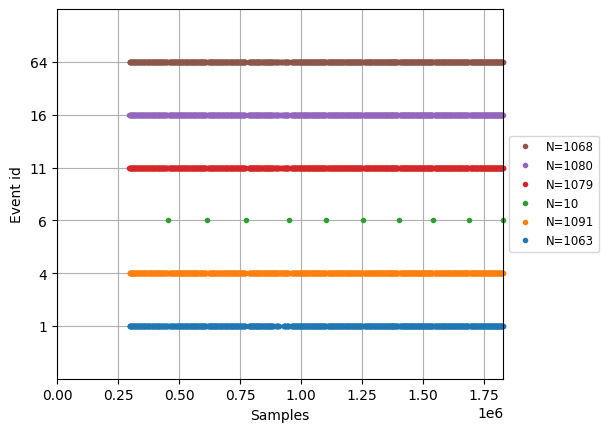

In [11]:
mne.viz.plot_events(events);

# ICA

To remove artifacts we'll use independent component analysis (see MNE's tutorials, e.g. https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py)

## Preparing for ICA

We fit the ICA on the continuous EEG signal but to avoid taking beginning and end of the recording as well as (eventual) breaks in the experiment, which are often very noisy, we annotate the long sections without stimulus triggers.

### Annotation of very long RTs/breaks

In [12]:
all_events = np.array(np.unique(events[:,2]))
stim_trigger = all_events[np.isin(all_events, [11])] # stim trigger only includes T1 stimulus
stim = np.array([x for x in events if x[-1] in  stim_trigger])

color_dict = {k:'b' for k in stim_trigger}

stim_events = np.array([list(x) for x in events if x[2] in stim_trigger])
stim_events

array([[ 296686,       0,      11],
       [ 298153,       0,      11],
       [ 299621,       0,      11],
       ...,
       [1824107,       0,      11],
       [1825421,       0,      11],
       [1826786,       0,      11]], dtype=int64)

In [13]:

estimated_duration_breaks = 6 #seconds
onset_breaks = stim_events[np.where(np.diff(stim_events[:,0], n=1) > (raw.info['sfreq']*estimated_duration_breaks))][:,0]/raw.info['sfreq'] #detecting latencies between triggers > x sec
offset_breaks = np.flip(np.flip(stim_events)[np.where(np.diff(np.flip(stim_events[:,0]), n=1) < -(raw.info['sfreq']*estimated_duration_breaks))])[:,0]/raw.info['sfreq']

onset_breaks = onset_breaks + 3 #add 3 sec after last stimulus trigger
offset_breaks = offset_breaks - .6 #removes 600 msec before next stimulus trigger

onset_breaks = np.insert(onset_breaks,0,0)#just adding start of the recording to the breaks
onset_breaks = np.insert(onset_breaks,-1, stim_events[-1,0]/raw.info['sfreq']+3)#just adding end of the recording to the breaks

offset_breaks = np.insert(offset_breaks,0,stim_events[0,0]/raw.info['sfreq']-.6)#just adding start of the recording to the breaks
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())#just adding end of the recording to the breaks


duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(len(duration_breaks))
break_annot = mne.Annotations(onset= np.insert(onset_breaks,0,0),#just adding start of the recording to the breaks
                           duration=np.insert(duration_breaks,0, stim_events[0,0]/raw.info['sfreq']-1),
                           description=['BAD_breaks'])
raw.set_annotations(break_annot);

18


15 of such periods where found and annotated so excluded from future data processing

Save every step up to now and before the actual fit of the ICA

In [14]:
raw.save(EEG_data_path+"preproc/pre_ica_%s.fif"%name_subj,overwrite=True)

Overwriting existing file.
Writing C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\pre_ica_VP1.fif


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\467714353.py:1: RuntimeWarning: This filename (C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\pre_ica_VP1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(EEG_data_path+"preproc/pre_ica_%s.fif"%name_subj,overwrite=True)


Closing C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\pre_ica_VP1.fif
[done]


# Fitting ICA

###  Resampling

In [15]:
raw = mne.io.read_raw_fif(EEG_data_path+"preproc/pre_ica_%s.fif"%name_subj, preload=True)#needed just in case of restart at this point

Opening raw data file ../data/eeg/preproc/pre_ica_VP1.fif...
    Range : 0 ... 1836543 =      0.000 ...  3586.998 secs
Ready.
Reading 0 ... 1836543  =      0.000 ...  3586.998 secs...


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\2786051234.py:1: RuntimeWarning: This filename (../data/eeg/preproc/pre_ica_VP1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(EEG_data_path+"preproc/pre_ica_%s.fif"%name_subj, preload=True)#needed just in case of restart at this point


In [16]:
# Downsampling to 500 Hz to reduce computational load. Note that while we fit the ICA on resampled data, the ICA based correction will be done on the original sampling frequency by reloading the data pre-ica before correction

raw, events = raw.resample(200, events=events)#passing the events avoids generating incorrect timing in events


Fit using the fastICA algorithm implemented by MNE. Add -1 to avoid rank deficiency linked to REST reference

In [17]:
ica = mne.preprocessing.ICA(n_components = len(raw.pick_types(eeg=True).ch_names)-1, method='fastica', max_iter='auto')
ica.fit(raw)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 144791 of 717400 (20.18%) samples, retaining 572609 (79.82%) samples.
Selecting by number: 63 components
Fitting ICA took 86.8s.


Method,fastica
Fit,67 iterations on raw data (572609 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Save the fitted ICA

In [18]:
ica.save(EEG_data_path+"preproc/ICA_object_%s.fif"%name_subj, overwrite=True);

Overwriting existing file.
Writing ICA solution to C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\ICA_object_VP1.fif...


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\2909459321.py:1: RuntimeWarning: This filename (../data/eeg/preproc/ICA_object_VP1.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(EEG_data_path+"preproc/ICA_object_%s.fif"%name_subj, overwrite=True);


### Visualizing on epochs

Now we fitted on the continuous data (minus breaks and bad portions), but we want to inspect how ICs behave at the epoch level. Hence we first epoch the data in order to take alook at those ICs

In [19]:
epochs = mne.Epochs(raw, stim, event_id=[int(x) for x in stim_trigger], tmin=-0.5, tmax=3, preload=True)#Epoch is -500ms up to 2000ms after stim, only for IC visualization

Not setting metadata
1079 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1079 events and 701 original time points ...
817 bad epochs dropped


### Inspection 
Here we open an interactive view to inspect components based on their topologies on the scalp. Clicking on their number marks them for exclusion, clicking on the topologies opens a view of the IC on different measures (see also [[zoom on suspicious ICs]])

In [20]:
%matplotlib qt 
#%matplotlib qt opens a separate window
ica.plot_components(inst=epochs);

### ICs epoch timecourse


Here we inspect each ICs time course during the whole experiment, very usefull to understand eventual functional properties of the identified ICs. 

In [21]:
ica.plot_sources(epochs, block=True)# opens a dynamic window when run

Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated


### zoom on suspsicious ICs

Before exclusions I take a look at those IC that I marked to be sure that those are the ones I want to exclude. A prompt at the end of the cell takes as input the number (separated by commas) of the ICs I really want to remove

In [22]:
ica.exclude


[0, 3, 8]

[0, 3, 8]
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated


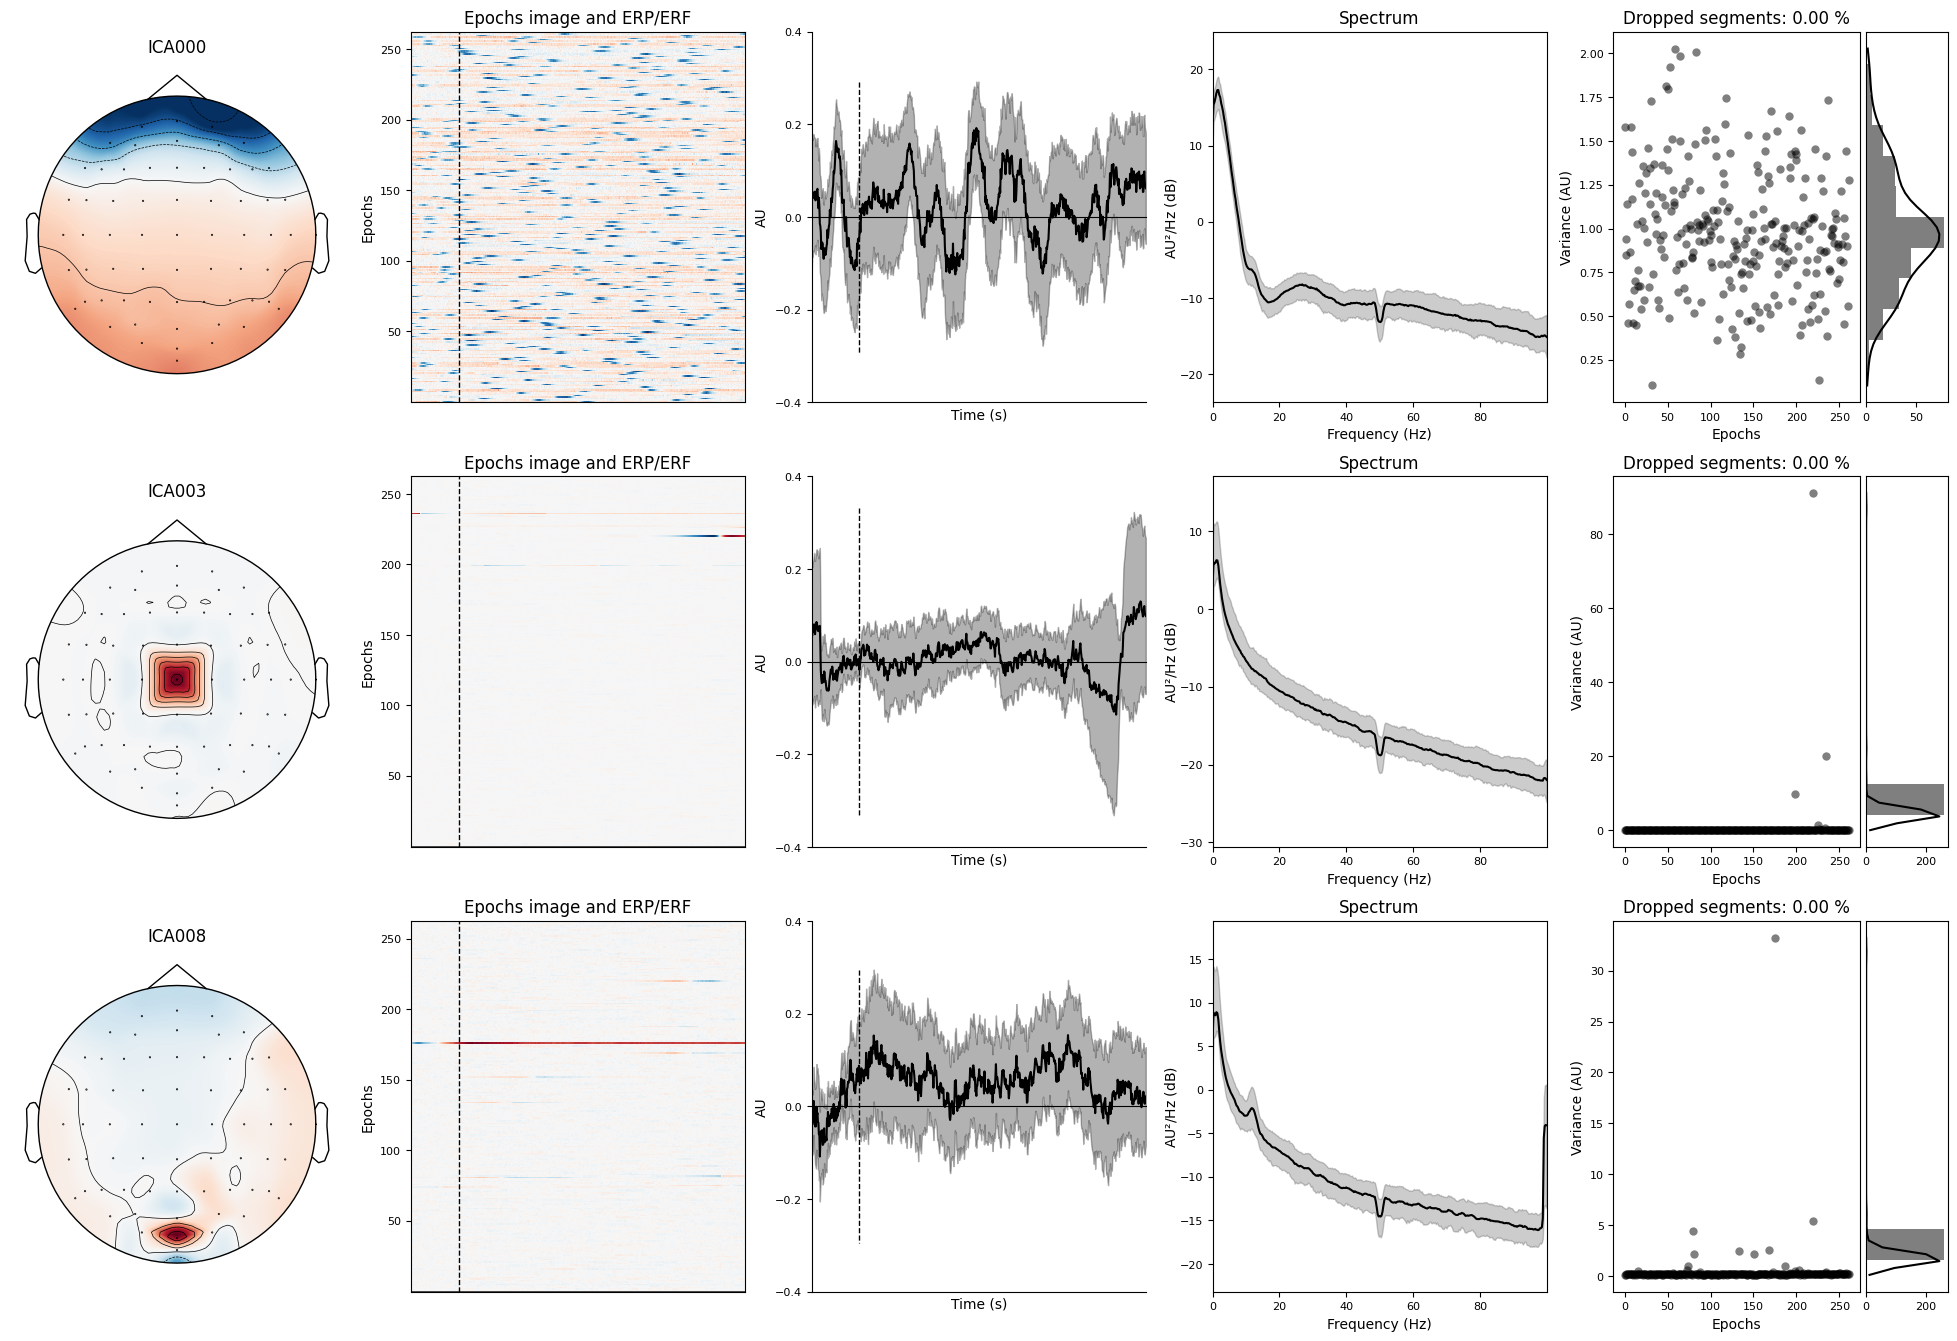

[]0,3,8


In [23]:
%matplotlib inline 
print(ica.exclude)
fig, ax = plt.subplots(len(ica.exclude), 5, figsize = (25, len(ica.exclude)*5))

i = 0
for comp in ica.exclude:
    ica.plot_properties(epochs, picks=comp, axes=ax[i,:], show=False);
    i += 1
plt.show()
ica.exclude = [int(x) for x in input([]).split(',')]

In this example IC0, 1 and 3 are clearly related to eye activities and, because I do not care much about frontal electrodes, can be removed. ICA019 for example is a, very localized, brain source as it looks based on the centrality of the activity and the alpha/beta like frequency.

## Final exclusions of ICA components :

Visualize the consequence of the correction on the data without yet applying it

[0, 3, 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying ICA to Evoked instance
    Transforming to ICA space (63 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\1652067466.py:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');


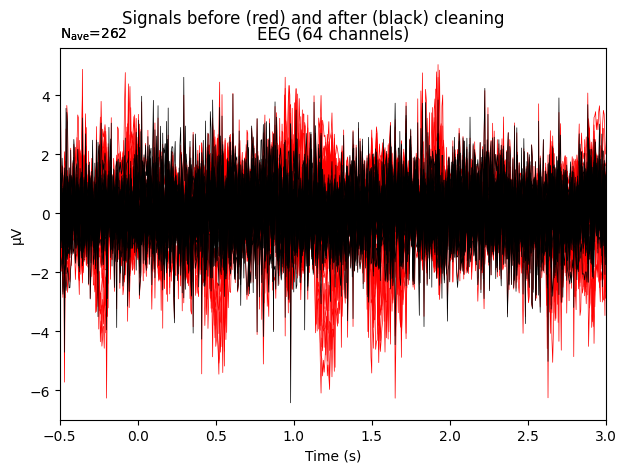

In [24]:
%matplotlib inline 
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

### Reloading original pre-ica data

In [25]:
raw = mne.io.read_raw_fif(EEG_data_path+"preproc/pre_ica_%s.fif"%name_subj, preload=True)

Opening raw data file ../data/eeg/preproc/pre_ica_VP1.fif...
    Range : 0 ... 1836543 =      0.000 ...  3586.998 secs
Ready.
Reading 0 ... 1836543  =      0.000 ...  3586.998 secs...


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\3761992409.py:1: RuntimeWarning: This filename (../data/eeg/preproc/pre_ica_VP1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(EEG_data_path+"preproc/pre_ica_%s.fif"%name_subj, preload=True)


You see here that we apply the ICA correction on the original raw data that wasn't downsampled

In [26]:
ica.apply(raw)


Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


<Raw | pre_ica_VP1.fif, 67 x 1836544 (3587.0 s), ~938.9 MB, data loaded>

## Interpolating the bad electrodes after ICA

Once we have done all that we can interpolate the bad channel we had

In [27]:
print(raw.info['bads'])
raw = raw.interpolate_bads()
raw.info['bads']


[]


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\2519011897.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads()


[]

And take a look at the new frequency decomposition

Setting 370659 of 1836544 (20.18%) samples to NaN, retaining 1465885 (79.82%) samples.
Effective window size : 4.000 (s)


C:\Users\maane008\AppData\Local\Temp\ipykernel_14124\1492956196.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw.compute_psd(fmax=80).plot();
C:\Users\maane008\Anaconda3\envs\hmp\lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


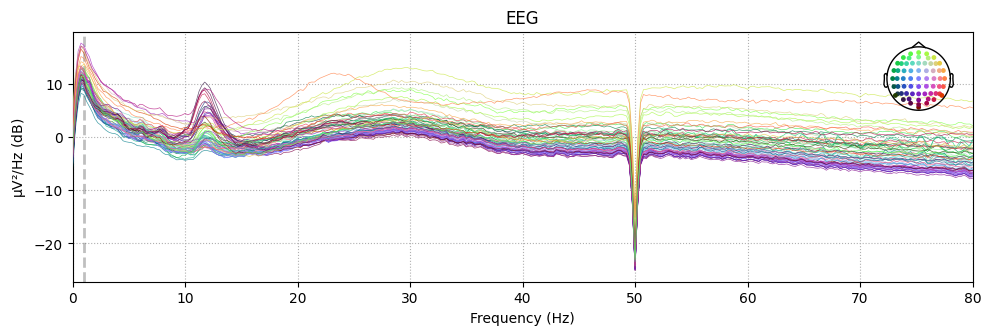

In [28]:
raw.compute_psd(fmax=80).plot();

Save the post ICA correction

In [29]:
raw.save(EEG_data_path+"preproc/post_ica_%s_raw.fif"%name_subj,overwrite=True)

Overwriting existing file.
Writing C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\post_ica_VP1_raw.fif
Closing C:\Users\maane008\Dropbox\Projects\EEG-PRP\preproc\..\data\eeg\preproc\post_ica_VP1_raw.fif
[done]


# Auto-reject remaining artifacts

Autoreject (https://autoreject.github.io/v0.2/index.html) is a very useful tool for post-ICA preprocessing (but some also like to use it before, see the website). We first epoch the data and then try to find electrode-wise optimal thresholds based on a cross-validation method. The resulting solution is a way to interpolate electrodes that exceed their respective thresholds as long as no ttoo many of them have to be interpolated within a given trial (otherwise the trial is rejected)

## Creating epochs

The method works on epoched data, hence we first decompose the continuous data based on the stimulus triggers that were sent in the experiment

In [30]:
raw = mne.io.read_raw_fif(EEG_data_path+"preproc/post_ica_%s_raw.fif"%name_subj, preload=True)

Opening raw data file ../data/eeg/preproc/post_ica_VP1_raw.fif...
    Range : 0 ... 1836543 =      0.000 ...  3586.998 secs
Ready.
Reading 0 ... 1836543  =      0.000 ...  3586.998 secs...


In [31]:
events = eventsTMP

In [ ]:
stim_id = {'stimulus/t1':11, 'stimulus/t2': 64}
response_id = {'response/t1':1,'response/t2':4} 

# Get the existing event onsets for the specific trigger sets
existing_event_onsets_set1 = np.concatenate([events[events[:, 2] == stim_id['stimulus/t1'], 0]])
existing_event_onsets_set2 = np.concatenate([events[events[:, 2] == stim_id['stimulus/t2'], 0]])

def find_condition(existing_event_onsets_set1, existing_event_onsets_set2):
    new_events = []
    
    for x in existing_event_onsets_set1:
        # the time difference between the two stimuli is computed by finding for every stim1 the closest positive difference with all stim2
        diff = existing_event_onsets_set2 - x
        valid_indices = np.where(diff > 0)
        closest_index = np.argmin(diff[valid_indices]) 
        if diff[valid_indices][closest_index] > 600 and diff[valid_indices][closest_index] < 615: # to allow for some variation in the samples
            new_events.append([x, 0, 256])  # long delay
        elif diff[valid_indices][closest_index] > 140 and diff[valid_indices][closest_index] < 151:
            new_events.append([x, 0, 512])  # short delay
        else:
            new_events.append([x, 0, 1024])  # exclude
    return new_events

# Identify new events across trigger sets and consider only the two nearest events
new_events = find_condition(existing_event_onsets_set1, existing_event_onsets_set2)

# Convert the event list to an events array (shape: (n_events, 3))
new_events = np.array(new_events)
events = np.concatenate((events, new_events))


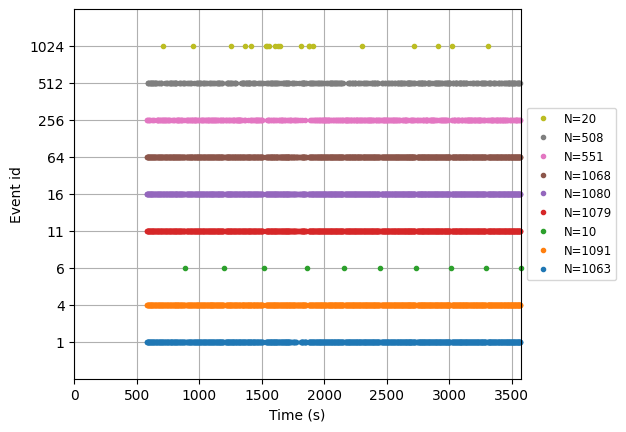

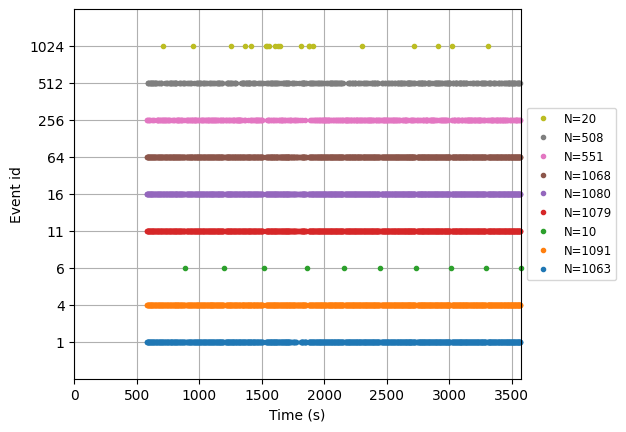

In [33]:
#events = mne.find_events(raw,min_duration= 2 / raw.info['sfreq'])
mne.viz.plot_events(events, sfreq=raw.info["sfreq"])


In [34]:

#In this decision-making experiment, triggers are SOA (short or long) and response
all_events = np.array(np.unique(events[:,2]))
stim_trigger_values = all_events[all_events==1]#stimulus intensity values
condition_id = {"condition/short":512, "condition/long":256}#condition trigger

stim_id = {'stimulus/t1':11}#, 'stimulus/t2':64} # use the interval from stim 1 to respnose 2 for epoch
response_id = {'response/t2':4, 'response/t1':1} 
event_id = condition_id | stim_id | response_id #all retained events

tmin = -0.25 #tmin is how much data (in s) needs to be used for baseline correction
tmax = 3 #tmax is how much far in time from stim should we look for a response

stim = list(stim_id.keys())#values to center the epochs on

#here we create a metadata structure, very useful to use triggers outside of those used for centering (here condition and response)
# of relevance is the T2 response, as that determines the end of the epoch
metadata, events, event_id = mne.epochs.make_metadata(
    events=events, event_id=event_id, tmin=tmin, tmax=tmax,
    sfreq=raw.info["sfreq"], row_events=stim, keep_first=["condition"])#, keep_last=["response"])




In [35]:
#[metadata.groupby(['first_condition', 'event_name'])['rt1'].mean(), metadata.groupby(['first_condition', 'event_name'])['rt2'].mean()]
#metadata.groupby('first_condition')['rt2'].mean()
[metadata.groupby('first_condition')['response/t1'].min(), metadata.groupby('first_condition')['response/t2'].min()]


[first_condition
 long     0.152344
 short    0.144531
 Name: response/t1, dtype: float64,
 first_condition
 long     0.322266
 short    0.443359
 Name: response/t2, dtype: float64]

In [36]:
#If you get a RuntimeWarning about no matching event found this is normal as sometime a few combinations are absent (e.g. no trial with accuracy condition, left expected response and contrast of 92)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)

Adding metadata with 8 columns
1079 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1079 events and 1665 original time points ...
17 bad epochs dropped


In [37]:
keep_cols = ['response/t1','response/t2', 'first_condition']
metadata = metadata[keep_cols]
metadata.reset_index(drop=True, inplace=True)#This allows to preserve the trial number after the rejections performed by the mne.Epochs function
metadata.columns = ['rt1','rt2', 'condition']#More convenient names

metadata


,rt1,rt2,condition
0,1.406250,1.734375,long
1,0.685547,1.757812,long
2,0.537109,0.810547,short
3,0.720703,0.943359,short
4,0.830078,1.285156,short
...,...,...,...
1074,0.386719,1.427734,long
1075,0.503906,0.847656,short
1076,0.466797,1.451172,long
1077,0.316406,1.564453,long


Epoch are dropped during the epoching because an artifact (or a break) was present between tmin and tmax. The following plot shows you how many, but more details can be found in ```epochs.drop_log()```

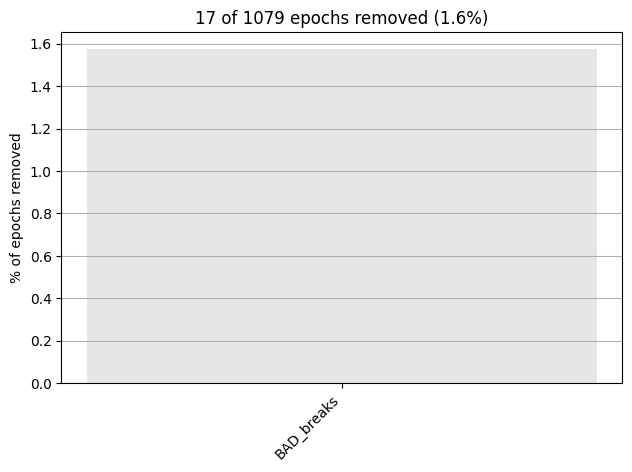

In [38]:
epochs.plot_drop_log();

## Auto-reject on remaining artifacts

Takes some time (and resources) to run

In [39]:
import autoreject #version 0.3.1 https://autoreject.github.io/
ar = autoreject.AutoReject()#consensus=np.linspace(0, .5, 11), n_jobs=-1) #I constrain the consensus parameter to be <=.5 as trials with more than half bad chan should be rejected
ar.fit(epochs[0:20])  # fit on the first 20 epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1062 [00:00<?,       ?it/s]

Dropped 225 epochs: 63, 97, 98, 107, 108, 109, 148, 150, 158, 203, 206, 207, 209, 224, 225, 245, 250, 252, 253, 266, 290, 320, 322, 349, 350, 363, 380, 382, 391, 393, 407, 408, 419, 420, 429, 434, 435, 462, 463, 502, 505, 506, 518, 519, 520, 521, 522, 523, 529, 531, 532, 535, 537, 544, 545, 546, 547, 551, 552, 553, 555, 557, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 572, 573, 576, 579, 580, 585, 588, 608, 621, 631, 633, 634, 652, 655, 656, 659, 660, 661, 668, 684, 691, 692, 693, 702, 706, 707, 727, 732, 738, 739, 740, 741, 747, 748, 752, 753, 760, 761, 762, 763, 766, 767, 768, 769, 770, 771, 773, 774, 775, 776, 777, 778, 779, 780, 782, 785, 786, 787, 788, 790, 791, 792, 795, 797, 801, 802, 803, 804, 805, 806, 807, 809, 814, 817, 820, 821, 823, 826, 828, 829, 830, 831, 832, 835, 838, 839, 840, 842, 843, 844, 846, 847, 848, 852, 853, 855, 857, 859, 860, 873, 874, 875, 876, 877, 879, 882, 883, 887, 888, 893, 894, 899, 901, 910, 911, 914, 918, 919, 920, 923, 934, 937, 938, 939

The following plots summarize what was done by autoreject

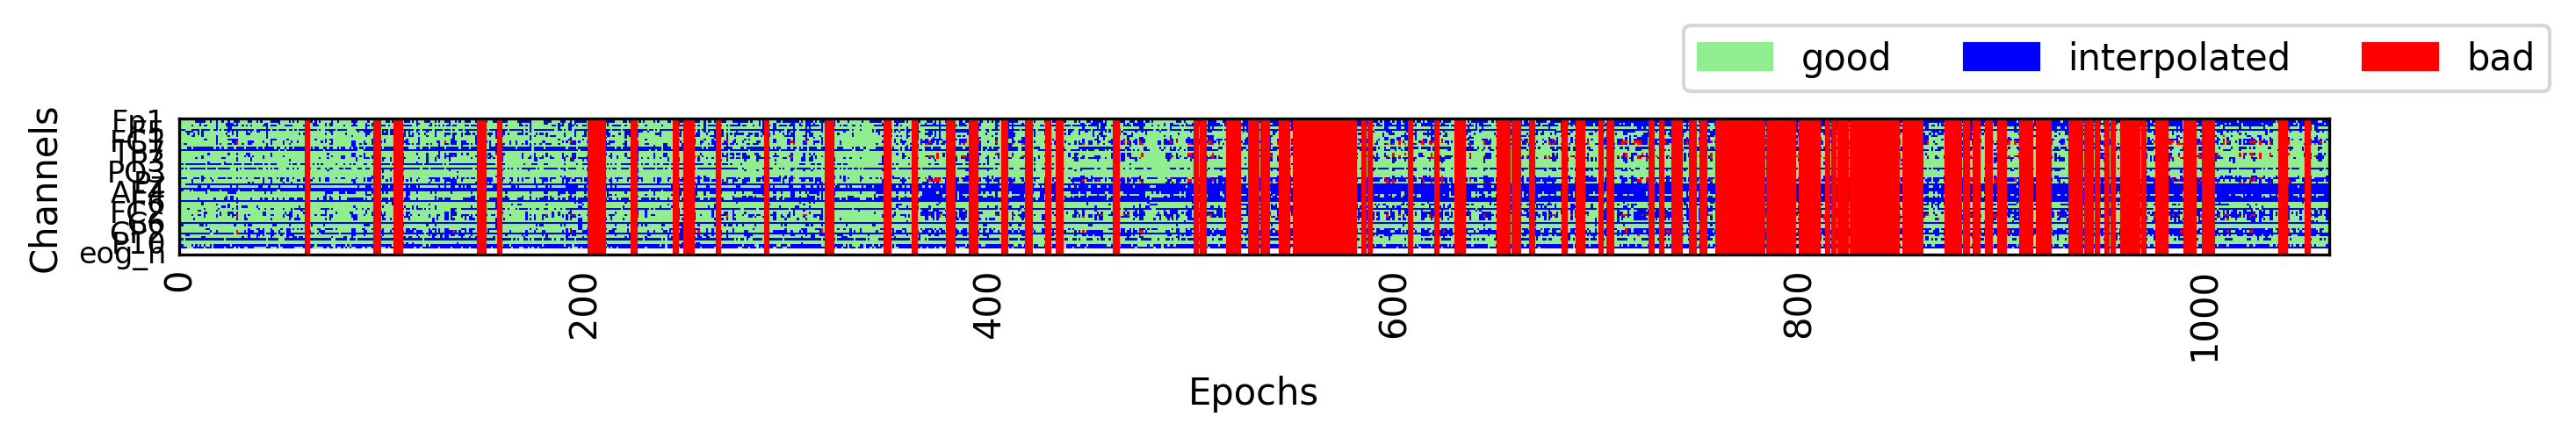

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


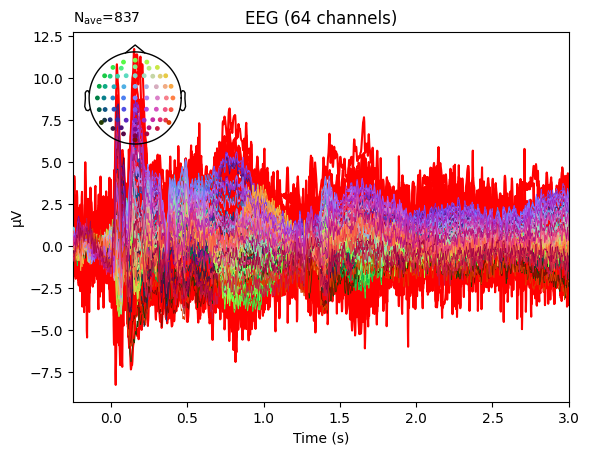

In [40]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,20), dpi=300)
reject_log.plot('horizontal', ax=ax)
plt.show()
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca()); #Compare ERP of rejected vs not rejected

Now we can review what the algorithm did. If we don't agree with, e.g. when the trial was rejected rather than interpolated or the rejection threshold we can adjust the parameters in the ```AutoReject``` function

I would rather recommend to constrain the algortihm in such a way that it remains conservative so that eventually we mark some more trials as bad (as in the next cell) rather than automatically rejecting a lot of epochs.

The ```plot_drop_log()``` now shows the total amount of dropped epochs and those that come from the previous visual rejection and those rejected based on autoreject

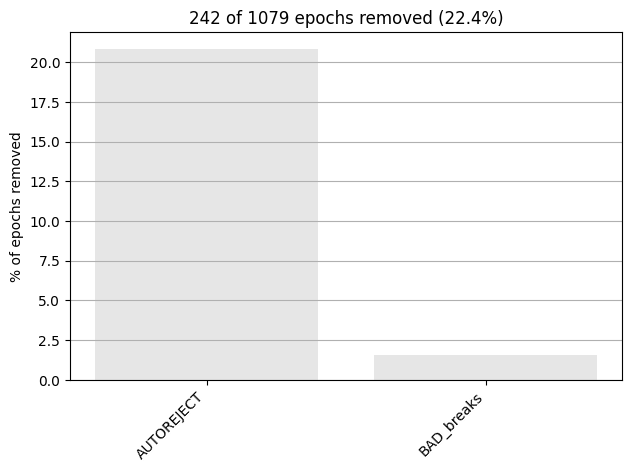

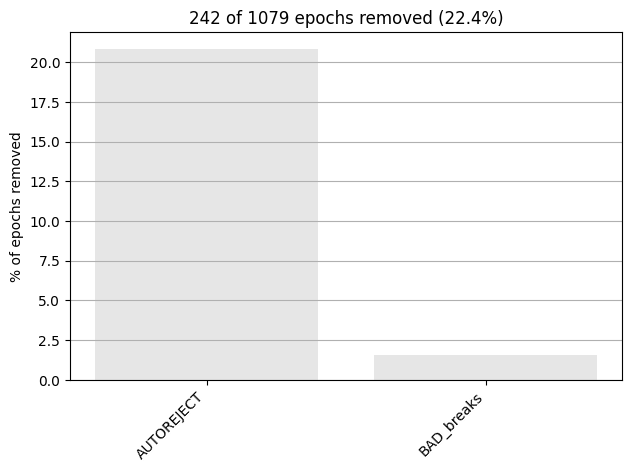

In [41]:
epochs_ar.plot_drop_log()

Then we save the data and can use them in further processing

In [42]:
keep_cols = ['response/t1','response/t2', 'first_condition']
epochs_ar.metadata = epochs_ar.metadata[keep_cols]
epochs_ar.metadata.reset_index(drop=True, inplace=True)#This allows to preserve the trial number after the rejections performed by the mne.Epochs function
epochs_ar.metadata.columns = ['rt1','rt2', 'condition']#More convenient names

epochs_ar.save(EEG_data_path+'preproc/%s_epo.fif'%name_subj, overwrite=True)

Replacing existing metadata with 3 columns
